<a href="https://colab.research.google.com/github/dnguyend/regularMTW/blob/main/colab/Multivariate_t_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Workbook to demonstrate using an optimal map to compute probability and expectation of a multivariate t distribution.


In [1]:
import numpy as np
import numpy.linalg as la
from scipy.integrate import tplquad, quad
from scipy.special import gammaln
import matplotlib.pyplot as plt

n = 3
np.random.seed(0)
def W(y, A, nu):
    return - gammaln((nu+n)/2) + gammaln(nu/2) \
      + 1/2*(n*np.log(np.pi*nu) + np.log(la.det(A))) \
      + (nu+n)/2*np.log(1 + 1/nu*(y).dot(la.solve(A, y)))



* The following show the challenge if we start from a uniform distribution on a hypercube of large radius. We use exact integration for $n=3$ and naive MC for $n=5$ and $n=10$

In [2]:
nu = 2.

a = - 10
b = 10

print(tplquad(lambda x, y, z: np.exp(-W(np.array([x, y, z]), np.eye(n), nu)), a, b, a, b, a, b, args=(), epsabs=1.49e-05, epsrel=1.49e-05))




(0.979355423381039, 1.4658936672283904e-05)


At $n=10$, the naive simulation only capture 70% of probability using $N=1000$, with

In [3]:
def WI(y, nu):
    n = y.shape[0]
    return - gammaln((nu+n)/2) + gammaln(nu/2) \
      + 1/2*(n*np.log(np.pi*nu)) \
      + (nu+n)/2*np.log(1 + 1/nu*np.sum(y*y, axis=0))

np.random.seed(0)
N = 100000
nu = 2

n = 5
vals = []
for i in range(1000):
  X = np.random.uniform(a, b, (n, N))
  vals.append(np.exp(-WI(np.array(X), nu)).mean()*((b-a)**n))
vals = np.array(vals)
print(f"n={n} mean={vals.mean()} std={vals.std()}")

n = 10
vals = []
for i in range(1000):
  X = np.random.uniform(a, b, (n, N))
  vals.append(np.exp(-WI(np.array(X), nu)).mean()*((b-a)**n))
vals = np.array(vals)
print(f"n={n} mean={vals.mean()} max={vals.max()} min={vals.min()} std={vals.std()}")


n=5 mean=0.9878478047869803 std=0.2479512423002884
n=10 mean=0.6481603775351454 max=79.87301541771325 min=0.12898757566219987 std=2.9050441017621433


Better: Evaluating using the scipy library package multivariate_t. This uses the representation of the distribution by chi-square.

In [4]:
from scipy.stats import multivariate_t
d = 30
vals = []
rpts = 15
for i in range(rpts):
  rvs = multivariate_t.rvs(np.zeros(d),  df=10, size=(100000))
  vals.append((rvs[:, 0]**2).mean())
vals = np.array(vals)
print(np.mean(vals))
print(np.std(vals))
# print(tplquad(lambda x, y, z: (x**2)*np.exp(-WI(np.array([x, y, z]), 10)), a, b, a, b, a, b, args=(), epsabs=1.49e-05, epsrel=1.49e-05))

1.2490684188873111
0.005904361774195833


So far so good - now try to evaluate probability of a strip, probabilyty where $LY > -1$. We see at large dimensions of 100 and 150, the simulation returns zero.

In [5]:
def run_scipy_t_rvs(n):

  nu = 10

  Sig = np.linalg.inv(0.5*(np.eye(n) + np.ones(n)[:, None]@np.ones(n)[None, :]))
  L = np.linalg.cholesky(Sig)
  vals = []

  for i in range(100):
    rvs = multivariate_t.rvs(np.zeros(n),  df=10, size=(100000)).T
    Ls = L@rvs
    mask = np.ones(rvs.shape[1])
    mask[np.logical_not(np.prod(Ls > -1, axis=0))] = 0
    vals.append(mask.mean())
  return np.array(vals)

for n in [5, 50, 100, 150]:
  vals = run_scipy_t_rvs(n)
  print(f"n={n} mean={vals.mean()}, max={vals.max()}, min={vals.min()} std={vals.std()}, std ratio = {vals.std()/vals.mean()}")



n=5 mean=0.19816139999999996, max=0.20162, min=0.19466 std=0.0013400992649800236, std ratio = 0.006762665508923654
n=50 mean=3.700000000000001e-06, max=3e-05, min=0.0 std=6.731270311018568e-06, std ratio = 1.819262246221234


<ipython-input-5-e49d2b547900>:19: RuntimeWarning: invalid value encountered in scalar divide
  print(f"n={n} mean={vals.mean()}, max={vals.max()}, min={vals.min()} std={vals.std()}, std ratio = {vals.std()/vals.mean()}")


n=100 mean=0.0, max=0.0, min=0.0 std=0.0, std ratio = nan
n=150 mean=0.0, max=0.0, min=0.0 std=0.0, std ratio = nan


## Some remarks
* Comparing with the "naive" sample, using the chi-square representation is powerful. Without it we are at a disadvantage. However simulation for high dimension is hard.

* OT can help: we do not use the chi-square representation, but we can still sample at high dimension.
* We will show OT avoids this problem, starting with a density only. The following are the main functions that we use.

## The OT framework
* The function random_ball generates a random point in the uniform distribution in a ball with a given radius
* VC is $WI(T_{\phi}(x), \nu) - \log \det T_{\phi}$, where $WI$ is the negative log likelihood of the multivariate t distribution, normalized with zero location and unit scaling matrix, of $\nu$, and $T_{\phi}$ is the optimal map for $\phi = \frac{1}{2}x^TC x$ for a given positive definite matrix $C$, with cost $c(x^Tx) = -\frac{1}{r}\sinh (r x^Tx)$.
$$T_{\phi}(x) = (1- r^2(x^TCx)^2)^{-\frac{1}{2}}Cx
$$
  * $x$ is drawn from the ellipsoid ball $x^TCx < \frac{1}{r}$. We draw using random_ball then multiply by $L$, $LL^T = C$
* $VC\_adj = VC - \log Vol( B)$,
$Vol (B) = \det(C)^{-\frac{1}{2}} r^{-\frac{1}{2}}\frac{\pi^{\frac{n}{2}}}{\Gamma(\frac{n}{2}+1)}
$
* $VI\_adj$ is $VC\_adj$ with $C= I$, implement to avoid matrix multiplication



In [9]:

def random_ball(N, n, radius=1.):
  random_directions = np.random.randn(n, N)
  random_directions /= la.norm(random_directions, axis=0)
  # Generate a random radius with probability proportional to
  # the surface area of a ball with a given radius.
  random_radii = np.random.uniform(0., 1., N) ** (1/n)
  # return the list of random (direction & length) points.
  return radius * (random_directions * random_radii)

def VC(C, logdetC, x, nu):
  # $WI(T_{\phi}(x), \nu) - \log \det T_{\phi}$
  px2 = np.sum(x*(C@x), axis=0)
  y = ((1-r**2*px2**2)**(-.5))[None, :]*(C@x)

  return WI(y, nu) - np.log((1-r**2*px2**2)**(-n/2-1)*(1+r**2*px2**2)) - logdetC


def VCadj(C, logdetC, x, nu):
  px2 = np.sum(x*(C@x), axis=0)
  y2 = np.sum(x*(C@C@x), axis=0)
  return - gammaln((nu+n)/2) + gammaln(nu/2) \
    + 1/2*n*np.log(np.pi*nu) \
    + (nu+n)/2*np.log(1 + 1/nu*(1-r**2*px2**2)**(-1)*y2) \
    + (n/2+1)*np.log((1-r**2*px2**2)) \
    - np.log(1+r**2*px2**2) \
    - (n/2)*np.log(np.pi) \
    + gammaln(n/2+1) \
    + n/2*np.log(r) \
    - .5*logdetC

def VIadj(x, nu):
  n = x.shape[0]
  px2 = np.sum(x*x, axis=0)
  # y = ((1-r**2*px2**2)**(-.5))[None, :]*(ptA.A@x)
  y2 = np.sum(x*x, axis=0)
  return - gammaln((nu+n)/2) + gammaln(nu/2) \
    + n/2*np.log(r*nu) \
    + (nu+n)/2*np.log(1 + 1/nu*(1-r**2*px2**2)**(-1)*y2) \
    + (n/2+1)*np.log((1-r**2*px2**2)) \
    - np.log(1+r**2*px2**2) \
    + gammaln(n/2+1)

def iOptMap(y, r):
    w2 = np.sum(y**2, axis=0)
    return (2/(1+(1 + 4*r**2*w2**2)**.5))**.5*y


* Quick tests that the implementations are consistent.

In [7]:
n = 5
r = 1/3
X = random_ball(1000, 5, r)
display(r**2*np.max(np.sum(X*X, axis=0)))\

C = 0.5*(np.eye(n) + np.ones(n)[:, None]@np.ones(n)[None, :])
VolB = np.log(la.det(C)**(-1/2)*r**(-n/2)*np.pi**(n/2))-gammaln(n/2+1)
display(np.max(np.abs(VC(C, np.log(la.det(C)), X, nu=2) - VolB - VCadj(C, np.log(la.det(C)), X, nu=2))))

display(np.max(np.abs(VCadj(np.eye(n), 0., X, nu=2) - VIadj(X, nu=2))))


np.float64(0.012340906879819832)

np.float64(1.4432899320127035e-15)

np.float64(8.881784197001252e-16)

* The transported distribution
For $n=1$, the transported distribution is similar to a uniform distribution on the interval for $x$

Text(0.5, 1.0, 'Transported t distribution')

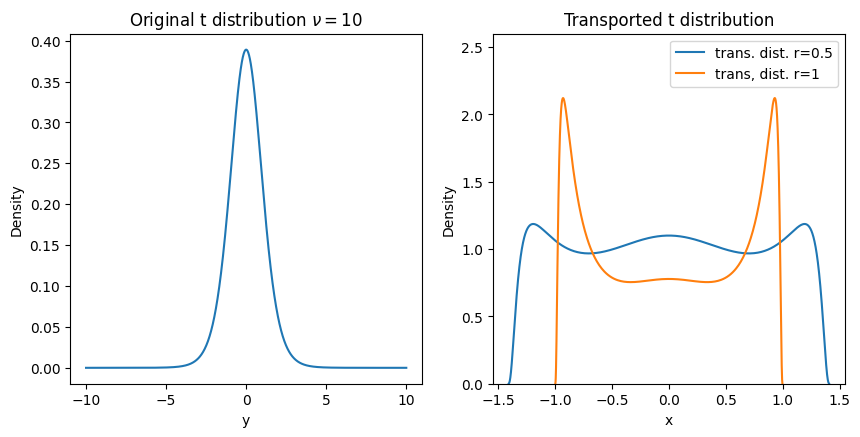

In [46]:
nu = 10
M = 10
n_pts = 1000

y = (M*np.arange(2*n_pts+1)/n_pts - M).reshape(1, -1)
pdf = np.exp(-WI(y, nu))
plt.figure(figsize=(10, 10))
plt.subplot(221)

# equivalent but more general
ax1 = plt.subplot(2, 2, 1)

# add a subplot with no frame
ax2 = plt.subplot(222)

ax1.plot(y[0, :], pdf)
# , label='original t distribution'

r = .5
x = iOptMap(y, r)
pdfx = VIadj(x, nu)

r = 1.
x1 = iOptMap(y, r)
pdfx1 = VIadj(x1, nu)

ax2.plot(x[0, :], np.exp(-pdfx), label='trans. dist. r=0.5')
ax2.plot(x1[0, :], np.exp(-pdfx1), label='trans, dist. r=1')
ax2.legend()

ax1.set_title(f"Original t distribution $\\nu={nu}$")
ax1.set_ylabel("Density")
ax1.set_xlabel("y")

ax2.set_ylabel("Density")
ax2.set_ylim(0, 2.6)
ax2.set_xlabel("x")


ax2.set_title("Transported t distribution")


Text(0.5, 1.0, 'Transported t distribution')

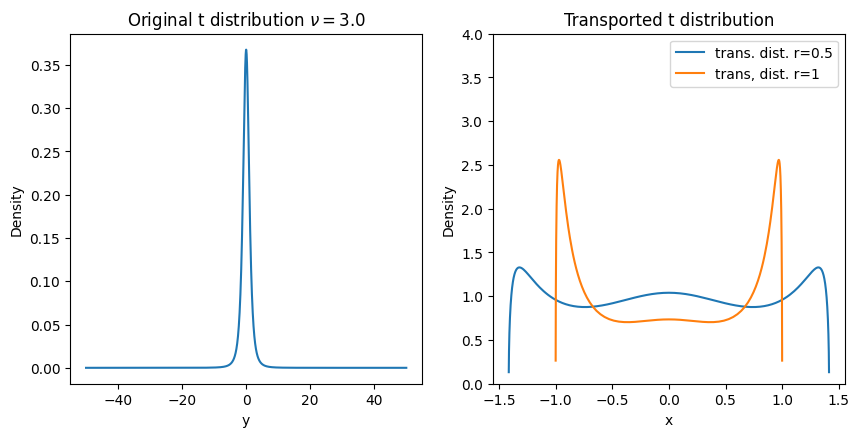

In [61]:
nu = 3.
M = 50
n_pts = 1000

y = (M*np.arange(2*n_pts+1)/n_pts - M).reshape(1, -1)
pdf = np.exp(-WI(y, nu))
plt.figure(figsize=(10, 10))
plt.subplot(221)

# equivalent but more general
ax1 = plt.subplot(2, 2, 1)

# add a subplot with no frame
ax2 = plt.subplot(222)

ax1.plot(y[0, :], pdf)
# , label='original t distribution'

r = .5
x = iOptMap(y, r)
pdfx = VIadj(x, nu)

r = 1.
x1 = iOptMap(y, r)
pdfx1 = VIadj(x1, nu)

ax2.plot(x[0, :], np.exp(-pdfx), label='trans. dist. r=0.5')
ax2.plot(x1[0, :], np.exp(-pdfx1), label='trans, dist. r=1')
ax2.legend()

ax1.set_title(f"Original t distribution $\\nu={nu}$")
ax1.set_ylabel("Density")
ax1.set_xlabel("y")

ax2.set_ylabel("Density")
ax2.set_ylim(0, 4.)
ax2.set_xlabel("x")


ax2.set_title("Transported t distribution")


# Run one test to comparable with [Table 1 of [1] ](https://inria.hal.science/hal-01240154v1/document)
Results are comparable.

[1] Botev, Z.I., L’Ecuyer, P.: Efficient probability estimation and simulation of the truncated multivariate student-t distribution. In: 2015 Winter Simulation Conference (WSC), pp. 380–391 (2015). https://doi.org/10.1109/WSC.2015.7408180

In [62]:
def run_one_cfg_VI(mask_func, Sig, n, nu, r, N, rpts):
  vals = []
  for i in range(rpts):
    X = random_ball(N, n, 1/np.sqrt(r))
    Yx = (1-r**2*np.sum(X*X, axis=0)**2)**(-.5)*X

    L = np.linalg.cholesky(Sig)
    Ls = L@Yx
    # spl1 = np.ones(Yx.shape[1])
    # spl1[np.logical_not(np.prod(Ls > -1, axis=0))] = 0
    vals.append((mask_func(Ls)*np.exp(- VIadj(X, nu))).mean())
  return np.array(vals)

np.random.seed(0)
nu = 10
r = .5
rpts = 100
n_samples = int(1e5)

def lb_m1(Ls):
    mask = np.ones(Ls.shape[1])
    mask[np.logical_not(np.prod(Ls > -1, axis=0))] = 0
    return mask

for n in [5, 10, 20, 30, 40, 50, 100, 150]:
  # for n in [150]:
  Sig = np.linalg.inv(0.5*(np.eye(n) + np.ones(n)[:, None]@np.ones(n)[None, :]))
  vals = run_one_cfg_VI(lb_m1, Sig, n, nu, r, n_samples, rpts)
  print(f"n={n} mean={vals.mean()}, max={vals.max()}, min={vals.min()} std={vals.std()}, std ratio = {vals.std()/vals.mean()}")


n=5 mean=0.19791200867889228, max=0.19991713734857633, min=0.19565456545495188 std=0.0009602237587205342, std ratio = 0.004851771073065482
n=10 mean=0.032516359456756065, max=0.03363018561640875, min=0.03149588909353675 std=0.0004411277279646065, std ratio = 0.013566332004395144
n=20 mean=0.0016359741325828179, max=0.0017820145885686213, min=0.0014967196492969071 std=5.653622745950744e-05, std ratio = 0.03455814265855784
n=30 mean=0.00014983018455536843, max=0.00016851213407983445, min=0.00012960901442032492 std=9.846171167577843e-06, std ratio = 0.06571553787240565
n=40 mean=2.0781350420564473e-05, max=2.742725553490015e-05, min=1.572662811653162e-05 std=2.3862406944288915e-06, std ratio = 0.11482606501200009
n=50 mean=3.721375056066711e-06, max=5.696122405586068e-06, min=2.41792499166586e-06 std=7.005583631448985e-07, std ratio = 0.18825255519537723
n=100 mean=6.734937969130631e-09, max=3.246699853848331e-08, min=1.912730446265706e-09 std=4.06817154693983e-09, std ratio = 0.604039942

Similar result for $r=1$

In [63]:
np.random.seed(0)
nu = 10
r = 1.
rpts = 100
n_samples = int(1e5)

for n in [5, 10, 20, 30, 40, 50, 100, 150]:
  Sig = np.linalg.inv(0.5*(np.eye(n) + np.ones(n)[:, None]@np.ones(n)[None, :]))
  vals = run_one_cfg_VI(lb_m1, Sig, n, nu, r, n_samples, rpts)
  print(f"n={n} mean={vals.mean()}, max={vals.max()}, min={vals.min()} std={vals.std()}, std ratio = {vals.std()/vals.mean()}")


n=5 mean=0.19795935103544443, max=0.20180120079093913, min=0.1946772001426549 std=0.0013037665971254986, std ratio = 0.006586031881323254
n=10 mean=0.03242153258242674, max=0.03363954909454968, min=0.03095325037987538 std=0.0004801543857363287, std ratio = 0.014809737464310496
n=20 mean=0.0016319217347312235, max=0.0018024381586083655, min=0.0015184733365462316 std=5.591073464673738e-05, std ratio = 0.03426067160993223
n=30 mean=0.0001506795260606037, max=0.00017226574943954724, min=0.00012460097968318678 std=9.78091943369802e-06, std ratio = 0.0649120666185538
n=40 mean=2.105614320035319e-05, max=2.7168088909084008e-05, min=1.7363580428732444e-05 std=2.072708337056822e-06, std ratio = 0.09843722648229591
n=50 mean=3.672599225704963e-06, max=5.211324700146761e-06, min=2.8535268872076684e-06 std=4.6123629285417313e-07, std ratio = 0.12558851769774523
n=100 mean=7.852614709875973e-09, max=3.6869591375334305e-08, min=3.0482095843601016e-09 std=4.5285500813409785e-09, std ratio = 0.5766932

Similar results if $C = \Sigma^{-1}$

In [64]:
def run_one_cfg_VC(mask_func, Sig, n, nu, r, N, rpts):
  vals = []

  C = la.inv(Sig)
  L = np.linalg.cholesky(Sig)
  logDetC = -2*np.sum(np.log(np.diagonal(L)))
  for i in range(rpts):
    X = L@random_ball(N, n, 1/np.sqrt(r))
    Yx = ((1-r**2*np.sum(X*(C@X), axis=0)**2)**(-.5))[None, :]*(C@X)
    Ls = L@Yx
    # spl1 = np.ones(Yx.shape[1])
    # spl1[np.logical_not(np.prod(Ls > -1, axis=0))] = 0

    vals.append((mask_func(Ls)*np.exp(- VCadj(C, logDetC, X, nu))).mean())
  return np.array(vals)

nu = 10
r = .5
rpts = 100
n_samples = int(1e5)

for n in [5, 10, 20, 30, 40, 50, 100, 150]:
  # for n in [5]:
  Sig = np.linalg.inv(0.5*(np.eye(n) + np.ones(n)[:, None]@np.ones(n)[None, :]))
  vals = run_one_cfg_VC(lb_m1, Sig, n, nu, r, n_samples, rpts)
  print(f"n={n} mean={vals.mean()}, max={vals.max()}, min={vals.min()} std={vals.std()}, std ratio = {vals.std()/vals.mean()}")


n=5 mean=0.1981491622946367, max=0.2016763640905345, min=0.19491514573956822 std=0.0013934869544101308, std ratio = 0.007032514991600589
n=10 mean=0.032493272330347815, max=0.03371531432365026, min=0.030745085565093786 std=0.0005635560346187099, std ratio = 0.01734377593272944
n=20 mean=0.0016304011328802826, max=0.001880946045000189, min=0.0014047677327791318 std=8.612433487356791e-05, std ratio = 0.05282401559757249
n=30 mean=0.0001522029551252578, max=0.0002034805833814973, min=0.00011887047544562481 std=1.6731077404835515e-05, std ratio = 0.10992610091615115
n=40 mean=2.0367240245050636e-05, max=4.707552831181828e-05, min=1.3556279677962129e-05 std=4.775540909521129e-06, std ratio = 0.23447167373015176
n=50 mean=3.7775023178555635e-06, max=9.961895679476744e-06, min=2.052662587895517e-06 std=1.2132107940595888e-06, std ratio = 0.32116745192318297
n=100 mean=6.136926547244498e-09, max=2.4013110584871505e-08, min=9.341895777112043e-10 std=4.31581913808801e-09, std ratio = 0.703254162

# Run for lower bound = 0

This corresponds to [Table 2 of [1] ](https://inria.hal.science/hal-01240154v1/document). Good to $n=10$. After that we get $0$.  We have not been able to investigate more, but this may have do with most Python procedures are good to $10^{-15}$, rather than the sampling method.

In [65]:
np.random.seed(0)
nu = 10
r = 1.
rpts = 100
n_samples = int(1e5)

def lb_0(Ls):
    mask = np.ones(Ls.shape[1])
    mask[np.logical_not(np.prod(Ls > 0, axis=0))] = 0
    return mask

for n in [5, 10, 20]:
  # for n in [5]:
  Sig = np.linalg.inv(0.5*(np.eye(n) + np.ones(n)[:, None]@np.ones(n)[None, :]))
  vals = run_one_cfg_VC(lb_0, Sig, n, nu, r, n_samples, rpts)
  print(f"n={n} mean={vals.mean()}, max={vals.max()}, min={vals.min()} std={vals.std()}, std ratio = {vals.std()/vals.mean()}")


n=5 mean=0.001937483979831405, max=0.0022260409668453268, min=0.0017390758450292754 std=9.441446149935478e-05, std ratio = 0.04873044757127256
n=10 mean=1.4365958820281438e-07, max=2.261584787566134e-06, min=0.0 std=3.6905648321041844e-07, std ratio = 2.568965203278986
n=20 mean=0.0, max=0.0, min=0.0 std=0.0, std ratio = nan


<ipython-input-65-5131cc49f520>:16: RuntimeWarning: invalid value encountered in scalar divide
  print(f"n={n} mean={vals.mean()}, max={vals.max()}, min={vals.min()} std={vals.std()}, std ratio = {vals.std()/vals.mean()}")


Run for another example with bound between $1$ and $3$, corresponding to
 [Table 3 of [1] ](https://inria.hal.science/hal-01240154v1/document).
In this case, $\Sigma$ is is close to degenerate so using VI is better than VC with $C=\Sigma^{-1}$.

In [66]:
np.random.seed(0)
nu = 10
r = .5
rpts = 100
n_samples = int(1e5)

def lb_1_3(Ls):
    mask = np.ones(Ls.shape[1])
    mask[np.logical_not(np.prod(np.logical_and(Ls > 1, Ls < 3), axis=0))] = 0
    return mask

for n in [5, 30, 50, 100, 150]:
  # for n in [5]:
  rho = 0.95
  Sig = (1-rho)*np.eye(n) + rho*np.ones(n)[:, None]@np.ones(n)[None, :]
  vals = run_one_cfg_VI(lb_1_3, Sig, n, nu, r, n_samples, rpts)
  print(f"n={n} mean={vals.mean()}, max={vals.max()}, min={vals.min()} std={vals.std()}, std ratio = {vals.std()/vals.mean()}")


n=5 mean=0.09925101249741008, max=0.10198458743807703, min=0.09704092044587302 std=0.0010779808893455994, std ratio = 0.010861157606565766
n=30 mean=0.059898095421006825, max=0.06280747567384279, min=0.05731651661625567 std=0.0010896706998354741, std ratio = 0.018192075927898642
n=50 mean=0.05199525535774294, max=0.05434343461831261, min=0.05006639805288003 std=0.0008609209587680009, std ratio = 0.016557683058667696
n=100 mean=0.04231360357988278, max=0.04509385272042603, min=0.04024764437158681 std=0.0009235247315839872, std ratio = 0.021825716872364422
n=150 mean=0.03743963796025896, max=0.03986508041016948, min=0.03539875543115894 std=0.0008417397992225611, std ratio = 0.02248258383577433


Code to parse the output

In [67]:
tabl1_str =[
"n=5 mean=0.19791200867889228, max=0.19991713734857633, min=0.19565456545495188 std=0.0009602237587205342, std ratio = 0.004851771073065482",
"n=10 mean=0.032516359456756065, max=0.03363018561640875, min=0.03149588909353675 std=0.0004411277279646065, std ratio = 0.013566332004395144",
"n=20 mean=0.0016359741325828179, max=0.0017820145885686213, min=0.0014967196492969071 std=5.653622745950744e-05, std ratio = 0.03455814265855784",
"n=30 mean=0.00014983018455536843, max=0.00016851213407983445, min=0.00012960901442032492 std=9.846171167577843e-06, std ratio = 0.06571553787240565",
"n=40 mean=2.0781350420564473e-05, max=2.742725553490015e-05, min=1.572662811653162e-05 std=2.3862406944288915e-06, std ratio = 0.11482606501200009",
"n=50 mean=3.721375056066711e-06, max=5.696122405586068e-06, min=2.41792499166586e-06 std=7.005583631448985e-07, std ratio = 0.18825255519537723",
"n=100 mean=6.734937969130631e-09, max=3.246699853848331e-08, min=1.912730446265706e-09 std=4.06817154693983e-09, std ratio = 0.6040399429937087",
"n=150 mean=8.953473336565207e-11, max=4.760185824458385e-10, min=1.0477218459217173e-11 std=8.988536281366378e-11, std ratio = 1.0039161276839879"]
ns, avgs, std = [], [], []

for st in tabl1_str:
  a = st.split()
  ns.append(int(a[0].split("=")[1]))
  avgs.append(float(a[1].split("=")[1][:-1]))
  std.append(float(a[4].split("=")[1][:-1]))

print("n &" + "&".join(f" {c:d}" for c in ns ) + "\\\\")
print("Probability &" +"&".join(f" {c:#.3g}" for c in avgs ) + "\\\\")
print("Std &" + "&".join(f" {std[i]:#.3g}" for i in range(len(std)) ) + "\\\\")



n & 5& 10& 20& 30& 40& 50& 100& 150\\
Probability & 0.198& 0.0325& 0.00164& 0.000150& 2.08e-05& 3.72e-06& 6.73e-09& 8.95e-11\\
Std & 0.000960& 0.000441& 5.65e-05& 9.85e-06& 2.39e-06& 7.01e-07& 4.07e-09& 8.99e-11\\


In [68]:


  # print(f"{ns[i]} & {avgs[i]} & {maxs[i]} & {mins[i]}\\\\")

Table 2 in the paper, table 3 in [1]

In [69]:
tabl2_str =[
"n=5 mean=0.09925101249741008, max=0.10198458743807703, min=0.09704092044587302 std=0.0010779808893455994, std ratio = 0.010861157606565766",
"n=30 mean=0.059898095421006825, max=0.06280747567384279, min=0.05731651661625567 std=0.0010896706998354741, std ratio = 0.018192075927898642",
"n=50 mean=0.05199525535774294, max=0.05434343461831261, min=0.05006639805288003 std=0.0008609209587680009, std ratio = 0.016557683058667696",
"n=100 mean=0.04231360357988278, max=0.04509385272042603, min=0.04024764437158681 std=0.0009235247315839872, std ratio = 0.021825716872364422",
"n=150 mean=0.03743963796025896, max=0.03986508041016948, min=0.03539875543115894 std=0.0008417397992225611, std ratio = 0.02248258383577433"]
ns, avgs, std = [], [], []
for st in tabl2_str:
  a = st.split()
  ns.append(int(a[0].split("=")[1]))
  avgs.append(float(a[1].split("=")[1][:-1]))
  std.append(float(a[4].split("=")[1][:-1]))
print("n &" + "&".join(f" {c:d}" for c in ns ) + "\\\\")
print("Probability &" +"&".join(f" {c:#.3g}" for c in avgs ) + "\\\\")
print("Std &" + "&".join(f" {std[i]:#.3g}" for i in range(len(std)) ) + "\\\\")


n & 5& 30& 50& 100& 150\\
Probability & 0.0993& 0.0599& 0.0520& 0.0423& 0.0374\\
Std & 0.00108& 0.00109& 0.000861& 0.000924& 0.000842\\
